# Testing out the Autotrail-TrailMap algorithm in a few test cases

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplleaflet
import geopandas as geopd
import srtm
import gpxpy
import networkx as nx
import process_gpx_data as gpx_process
import os
import shapely

from matplotlib import rc, cm
viridis = cm.get_cmap('viridis')
magma   = cm.get_cmap('magma')
plasma  = cm.get_cmap('plasma')


import maptrails

m_in_mi = 1609.34
m_in_ft = 0.3048

### Loading the Processed Dataset 
(this takes about ~5 minutes to regenerate if tweaked in the future)

In [2]:
#
# load the pickled traip map
#
outname = './data/boulder_area_trail_processed'
new_df, nodes, edges = gpx_process.load_trail_df(outname)
trailmap             = gpx_process.load_graph(outname)
trailmap.ensure_edge_attributes()

# Test Case 1:

This is to sanity check some of the non-algorithm routines. Computes the shortest path between two known-to-be-connected does using the NX algorithm and plots results

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
         2.16           402           114          5643          6955         -0.00          0.00          0.00


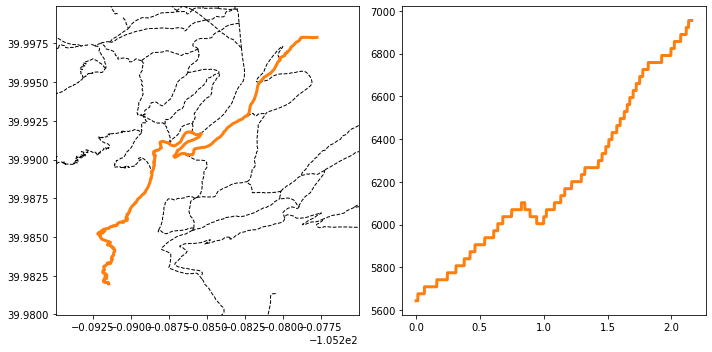

In [9]:
test_nodes = nx.shortest_path(trailmap, 1041, 1762)
test_edges = trailmap.edges_from_nodes(test_nodes)

#route_line = trailmap.reduce_edge_data('geometry', 
#                          edges = test_edges,
#                          function = gpx_process.combine_gpx)

route_totals = trailmap.route_properties(edges=test_edges)

fig, ax = maptrails.plot_trails(trailmap, edges=test_edges, show_profile=True, fs = 5)

## Test Case 1.1:

Using the above, now compute an algorithmified version of the same route

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
         7.56          1869          2171          5643          6955        -43.04          0.00          0.00


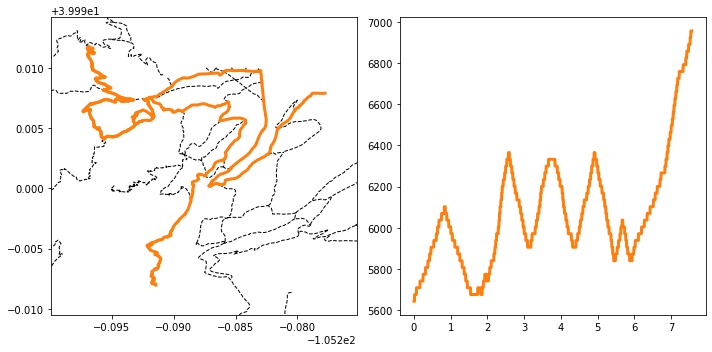

In [13]:
dist          = 20  * m_in_mi
# elev          = 3000.0 * m_in_ft

target_values = {'distance' : dist}


totals, test_nodes = trailmap.find_route(1041, 
                               target_values, 
                               end_node=1762)

test_edges = trailmap.edges_from_nodes(test_nodes)

route_totals = trailmap.route_properties(edges=test_edges)

fig, ax = maptrails.plot_trails(trailmap, edges=test_edges, show_profile=True, fs = 5)

## Test Case 2:

Testing out by picking a point in a known-to-be-connected area of Chautaqua and see how the algorithm performs making a route that completes a full round trip. Trying out a few constraints.

In [5]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = trailmap.nearest_node( test_coord[0], test_coord[1])

dist          = 25.0   * m_in_mi
elev          = 3000.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist}

totals, possible_routes =\
      trailmap.find_route(start_node, 
                          target_values, 
                          end_node=end_node)

#trailmap.write_gpx_file('test.xml',nodes=possible_routes)

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
        20.79          6418          6815          5643          8333        -47.39          0.00          0.00


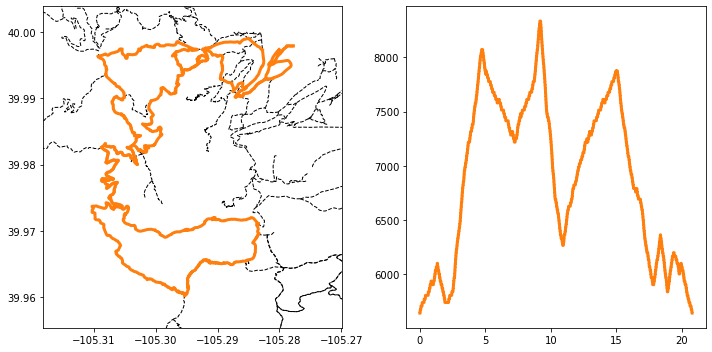

In [6]:
fig,ax=maptrails.plot_trails(trailmap, nodes=possible_routes, show_profile = True, fs = 5)
rprop = trailmap.route_properties(nodes=possible_routes)


In [7]:
break

SyntaxError: 'break' outside loop (<ipython-input-7-6aaf1f276005>, line 4)

In [ ]:
#
# Orphaned segments
#
orphan_list = []
for i in TrailMap.nodes:
    
    neighbors = [n for n in TrailMap.neighbors(i)]
    
    if len(neighbors) > 1:
        continue
        
    other_neighbors = [n for n in TrailMap.neighbors(neighbors[0])]
    
    if len(other_neighbors) > 1:
        continue
        
    if (other_neighbors[0] == i):
        if (neighbors[0],i) in orphan_list:
            continue
            
        orphan_list.append((i,neighbors[0]))
    
print("Number of Orphaned Segments: ", len(orphan_list))
print("Comprising a total distance of %.3f mi of trail "%(TrailMap.reduce_edge_data('distance',edges=orphan_list)*0.00062137))
#print(orphan_list)

In [ ]:
def old_plot(graph, node_order=None,
         weight='distance', zoom =True,
         region = None):
    
    #pos = nx.spring_layout(graph, weight=weight, seed = 12345)
    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)
    
    
    pos = {ni : np.array([n['long'],n['lat']]) for ni,n in graph.nodes(data=True)}
    
    pc = nx.draw_networkx_nodes(graph, pos, node_size=20, ax = ax)


    #edges = [(u,v)]
    etraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] > 0]
    enottraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] == 0]

    colors = 'black'
    if not (node_order is None):
        ecolor_int = [node_order.index(e[0]) for e in etraveled]
        #colors = magma((np.array(ecolor_int)+5) / ((1.0*len(node_order)+5)))
        colors = ["C%i"%i for i in ecolor_int]
        
    temp = nx.draw_networkx_edges(graph, pos, edgelist=etraveled, width=2, edge_color=colors, ax = ax)
    temp = nx.draw_networkx_edges(graph, pos, edgelist=enottraveled, width=2, style='dashed', ax = ax)
    
    

    travelled_edges = graph.edges_from_nodes(node_order)
    travelled_edges_counter = {x : 0 for x in np.unique(travelled_edges)}
    
    edge_labels = {}
    count = 0
    for (u,v,d) in graph.edges(data=True):
        
        if not((u,v) in edge_labels.keys()):
            edge_labels[(u,v)] = ''
    
    count = 1
    for (u,v) in travelled_edges:
        try:
            edge_labels[(u,v)] = edge_labels[(u,v)] + '%i '%(count)
        except:
            edge_labels[(v,u)] = edge_labels[(v,u)] + '%i '%(count)
            
        count = count + 1

    #try:
    #    edge_labels = { (u,v) : "%i"%(d['ShapeLen']) for (u,v,d) in graph.edges(data=True)}
    #except:    
    #    edge_labels = { (u,v) : "%i"%(d['SHAPESTLength']) for (u,v,d) in graph.edges(data=True)}
    temp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.5, ax = ax)
    
    temp = nx.draw_networkx_labels(graph, pos, labels={n:n for n,data in graph.nodes(data=True)}, font_size=17,
                            font_color = 'black')
    
    
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 200)
    
    start_point = graph.nodes[node_order[0]]
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 200)


    sep = 0.025
    if zoom:
        ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
        ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
        
    #print(pos)
    return pc,ax